In [ ]:
# import pandas as pd

# trains = []
# tests = []
# with open('dataset/label.txt', 'r') as label_f:
#   line = label_f.readline()
#   while line:
#     splitted = line.split(' ')
#     names = splitted[0].split('.')
#     if line.startswith('train_'):
#       trains.append([str(names[0] + '_aligned.' + names[1]), int(splitted[1][0]) - 1])
#     else:
#       tests.append([str(names[0] + '_aligned.' + names[1]), int(splitted[1][0]) - 1])

#     line = label_f.readline()

# pd.DataFrame(data=trains, columns=['path', 'label']).to_csv('dataset/train.csv', index=False)
# pd.DataFrame(data=tests, columns=['path', 'label']).to_csv('dataset/test.csv', index=False)

In [79]:
# pd.read_csv('logs/resnet18-e1-rgt-pretrainedt/train.log', sep='\t').iloc[0].labels.split(',')

In [60]:
import pandas as pd

CLASS_LABELS = {
    '0': 'Surprise',
    '1': 'Fear',
    '2': 'Disgust',
    '3': 'Happiness',
    '4': 'Sadness',
    '5': 'Anger',
    '6': 'Neutral',
}

pd.read_csv('dataset/train.csv')['label'].value_counts(), pd.read_csv('dataset/test.csv')['label'].value_counts()

(3    4772
 6    2524
 4    1982
 0    1290
 2     717
 5     705
 1     281
 Name: label, dtype: int64,
 3    1185
 6     680
 4     478
 0     329
 5     162
 2     160
 1      74
 Name: label, dtype: int64)

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from collections import Counter
import time
import torch
import os
import shutil
import copy

import PIL
from PIL import Image

import pathlib

import os
import time
import random
from tqdm import tqdm
import pytorch_lightning as pl
import torchvision
from torch import nn
from torchmetrics.functional import accuracy
from torchsummary import summary
from torch.utils.data import Subset

In [17]:
def log_to_file(log_path: str, epoch: str, train_acc, train_loss, val_acc, val_loss):
    append = f"{epoch},{train_acc},{train_loss},{val_acc},{val_loss}\n"
    full_path = os.path.abspath(os.getcwd()) + log_path
    
    with open(full_path, "a") as f:
        if os.path.getsize(full_path) <= 0:
            f.write("epoch,train_acc,train_loss,val_acc,val_loss\n")
            
        f.write(append)
            

def find_mean_std(dataset):
    assert dataset.ndim >= 2
    print(dataset.shape)
    
    temp = dataset.reshape(dataset.shape[-1], -1)
    
    print(temp.shape)
    
    return np.array(temp.mean(axis=1)) / 255.0, np.array(temp.std(axis=1)) / 255.0


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)  # pause a bit so that plots are updated
    
def load_image(path):
    img = Image.open(path)
    # img = Image.open(path)
    img.load()
    
    return transforms.ToTensor()(img)

# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [72]:
from os.path import exists

import torch
from torch.utils.data import random_split, Dataset, DataLoader

from torchvision.io import read_image, ImageReadMode
from torchvision import transforms

# id_dict = {}
# for i, line in enumerate(open('data/wnids.txt', 'r')):
#   id_dict[line.replace('\n', '')] = i

# Notes:
# 1: Surprise
# 2: Fear
# 3: Disgust
# 4: Happiness
# 5: Sadness
# 6: Anger
# 7: Neutral

CLASS_LABELS = {
    '0': 'Surprise',
    '1': 'Fear',
    '2': 'Disgust',
    '3': 'Happiness',
    '4': 'Sadness',
    '5': 'Anger',
    '6': 'Neutral',
}

IMG_PATH = 'dataset/img/'
# IMG_PATH = 'dataset/test/'
INPUT_SIZE=100*100

class CustomImageNetDataset(Dataset):
    def __init__(self, transform=None, train=True):
        self.img_path = IMG_PATH
        # self.df = pd.read_csv('dataset/train.csv' if train else 'dataset/test.csv')
        self.df = pd.read_csv('dataset/train.csv' if train else 'dataset/test.csv').sample(n=1000)

        self.transform = transform

    def __len__(self):
        return len(self.df.index)

    def get_targets(self):
        return self.df['label']

    def __getitem__(self, idx):
        obj = self.df.iloc[idx]
        image = load_image(self.img_path + obj['path'])
        label = obj['label']

        # if image.shape[0] == 1:
        #   image = read_image(self.img_path + obj['name'], ImageReadMode.GRAY)

        if self.transform:
          image = self.transform(image.type(torch.FloatTensor))

        return image, label

class CustomDataModule(pl.LightningDataModule):
    def __init__(self, train_transforms = None, test_transforms = None, bs=32):
        super().__init__()
        self.bs = bs
        
        self.transform = train_transforms
        
        self.test_transform = test_transforms

    def prepare_data(self):
        pass

    def __balance_val_split(self, dataset, val_split=0.):
        targets = np.array(dataset.get_targets())
        train_indices, val_indices = train_test_split(
            np.arange(targets.shape[0]),
            test_size=val_split,
            stratify=targets
        )
        
        train_dataset = Subset(dataset, indices=train_indices)
        val_dataset = Subset(dataset, indices=val_indices)

        return train_dataset, val_dataset

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            train_ds_all = CustomImageNetDataset(transform=self.transform, train=True)
            self.train_ds, self.val_ds = self.__balance_val_split(train_ds_all, val_split=0.05)

        if stage == "test" or stage == "predict" or stage is None:
            self.test_ds = CustomImageNetDataset(transform=self.test_transform, train=False)

        return self

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.bs)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.bs)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs)

    def predict_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.bs)

In [19]:
# class FacialClassification(nn.Module):
#     def __init__(self, in_channels=3):
#         super().__init__()

#         conv1_out_channels = 32
#         self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=conv1_out_channels, kernel_size=7, stride=2)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

#         layer1_out_channels = 64
#         self.layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=conv1_out_channels, out_channels=layer1_out_channels, kernel_size=3, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=layer1_out_channels, out_channels=layer1_out_channels, kernel_size=3, bias=False),
#             nn.BatchNorm2d(layer1_out_channels),
#         )

#         layer2_out_channels = 128
#         self.layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=layer1_out_channels, out_channels=layer2_out_channels, kernel_size=3, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=layer2_out_channels, out_channels=layer2_out_channels, kernel_size=3, bias=False),
#             nn.BatchNorm2d(layer2_out_channels),
#         )

#         layer3_out_channels = 64
#         self.layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=layer2_out_channels, out_channels=layer3_out_channels, kernel_size=3, bias=False),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=layer3_out_channels, out_channels=layer3_out_channels, kernel_size=3, bias=False),
#             nn.BatchNorm2d(layer3_out_channels),
#         )

#         # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

#         self.fc = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(in_features=layer3_out_channels, out_features=256),
#             nn.ReLU(),
#             nn.Linear(in_features=256, out_features=128),
#             nn.Dropout(p=0.5),
#             nn.Linear(in_features=128, out_features=len(CLASS_LABELS))
#         )
    
#     def forward(self, x):
#         # print(x.shape)
        
#         x = self.maxpool(self.relu(self.conv1(x)))
#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.fc(x)
#         # x = self.fc(x)
#         return x
#         # return nn.functional.softmax(x, dim=1)

class FacialClassification(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(kernel_size=3),
        )

        # self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(in_features=128, out_features=len(CLASS_LABELS))
        )
    
    def forward(self, x):
        # print(x.shape)
        x = self.conv_layer(x)

        x = self.fc(x)

        return x

summary(FacialClassification(1).to("cuda"), (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 94, 94]           1,600
              ReLU-2           [-1, 32, 94, 94]               0
            Conv2d-3           [-1, 64, 90, 90]          51,264
              ReLU-4           [-1, 64, 90, 90]               0
         MaxPool2d-5           [-1, 64, 30, 30]               0
            Conv2d-6          [-1, 128, 26, 26]         204,928
              ReLU-7          [-1, 128, 26, 26]               0
         AvgPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 128, 6, 6]         147,584
             ReLU-10            [-1, 128, 6, 6]               0
        AvgPool2d-11            [-1, 128, 2, 2]               0
          Flatten-12                  [-1, 512]               0
           Linear-13                  [-1, 128]          65,664
             ReLU-14                  [

In [42]:
class FacialClassificationResNet18(nn.Module):
    def __init__(self, in_channels=1, requires_grad=False, pretrained=True):
        super().__init__()

        # get the "features" portion of VGG19 (we will not need the "classifier" portion)
        self.model_ft = torchvision.models.resnet18(pretrained=pretrained)
        # freeze all parameters since we're only optimizing the target image
        for param in self.model_ft.parameters():
            param.requires_grad_(requires_grad)
        
        self.model_ft.conv1.in_channels = in_channels
        num_ftrs = self.model_ft.fc.in_features
        
        # Here the size of each output sample is set to 2.
        # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
        self.model_ft.fc = nn.Linear(num_ftrs, len(CLASS_LABELS))

    def forward(self, x):
      out = self.model_ft(x)

      return out
  
# FacialClassificationResNet18()
summary(FacialClassificationResNet18(3).to("cuda"), (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           9,408
       BatchNorm2d-2           [-1, 64, 50, 50]             128
              ReLU-3           [-1, 64, 50, 50]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

In [ ]:
class FocalLoss(nn.CrossEntropyLoss):
    ''' Focal loss for classification tasks on imbalanced datasets '''

    def __init__(self, gamma, alpha=None, ignore_index=-100, reduction='none'):
        super().__init__(weight=alpha, ignore_index=ignore_index, reduction='none')
        self.reduction = reduction
        self.gamma = gamma

    def forward(self, input_, target):
        cross_entropy = super().forward(input_, target)
        # Temporarily mask out ignore index to '0' for valid gather-indices input.
        # This won't contribute final loss as the cross_entropy contribution
        # for these would be zero.
        target = target * (target != self.ignore_index).long()
        input_prob = torch.gather(nn.functional.softmax(input_, 1), 1, target.unsqueeze(1))
        loss = torch.pow(1 - input_prob, self.gamma) * cross_entropy
        return torch.mean(loss) if self.reduction == 'mean'
               else torch.sum(loss) if self.reduction == 'sum'
               else loss

In [21]:
class LitFacialClassification(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        # self.save_hyperparameters()

        self.model = model

        self.criterion = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch

        y_hat = self.model(x)
        # print(y_hat[0], y[0])

        loss = self.criterion(y_hat, y)

        preds = torch.argmax(y_hat, dim=1)
        acc = accuracy(preds, y)

        self.log('train_loss', loss, on_step=False, on_epoch=True, logger=True, prog_bar=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, logger=True, prog_bar=True)

        return {'loss': loss, 'progress_bar': {'train_acc': acc}}

    def validation_step(self, batch, batch_idx):
        result = self.training_step(batch, batch_idx)

        return {'loss': result['loss'], 'progress_bar': {'val_acc': result['progress_bar']['train_acc']}}

    def validation_epoch_end(self, val_outputs):
        avg_val_loss = torch.tensor([x['loss'] for x in val_outputs]).mean()
        avg_val_acc = torch.tensor([x['progress_bar']['val_acc'] for x in val_outputs]).mean()

        return {'loss': avg_val_loss, 'progress_bar': {'val_acc': avg_val_acc}}

    def test_step(self, batch, batch_idx):
        result = self.training_step(batch, batch_idx)

        return {'loss': result['loss'], 'progress_bar': {'test_acc': result['progress_bar']['train_acc']}}


    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)

        return optimizer

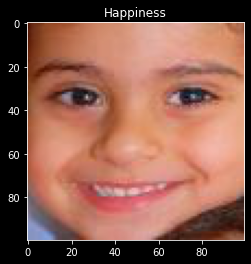

In [25]:
img, label = next(iter(CustomDataModule().setup("fit").train_dataloader().dataset))
# one_img = btx[0][0]
# one_label = btx[1][0]
# one_img.shape
# imshow(img)

plt.title(CLASS_LABELS[str(label)])
img =img.numpy()
if img.shape[0] == 3:
  img = img.transpose((1, 2, 0))
plt.imshow(img.squeeze(), cmap='gray' if img.shape[0] == 1 else None)

In [131]:

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 5
BATCH_SIZE = 32
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()

from sklearn.metrics import confusion_matrix
import seaborn as sns

def train(model, learning_rate, train_dl, val_dl, epochs, log_path: str):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

    for epoch in range(epochs):
        losses = []
        rtn_preds = []
        rtn_labels = []
        model.train()
        for images, labels in iter(train_dl):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            # print(images.shape, labels.shape)
            # Forward pass
            outputs = model(images)
            # print(outputs.shape)
            loss = criterion(outputs, labels)
            
            predicted = torch.argmax(outputs, dim=1).long()
            
            rtn_preds.extend(predicted.detach().cpu().numpy())
            rtn_labels.extend(labels.detach().cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
        scheduler.step()
            
        train_acc = (np.array(rtn_preds) == np.array(rtn_labels)).sum() / len(rtn_labels)
        
        val_loss, val_acc, val_labels, val_preds = evaluate(model, val_dl, testing=False)
        rtn_preds.extend(np.array(val_preds))
        rtn_labels.extend(np.array(val_labels))
            
        print ('Epoch [{}/{}], Training Loss: {:.4f}, Train Accuracy: {:.4f}' 
                      .format(epoch+1, epochs, sum(losses) / len(losses), train_acc))
        print ('Epoch [{}/{}], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}' 
                      .format(epoch+1, epochs, val_loss, val_acc))
        
        if not exists(log_path):
            os.mkdir(log_path)
            
        with open(log_path + "train.log", "a") as f:
            if os.path.getsize(log_path + "train.log") <= 0:
                f.write("epoch\ttrain_acc\ttrain_loss\tval_acc\tval_loss\tlabels\tpredictions\n")
                
            f.write(f"{epoch}\t{train_acc}\t{sum(losses) / len(losses)}\t{val_acc}\t{val_loss}\t{','.join([str(num) for num in rtn_labels])}\t{','.join([str(num) for num in rtn_preds])}\n")


def evaluate(model, val_dl, log_path = '', testing=True):
    # if testing:
    #     plt.figure(figsize=(50, 30))
    
    with torch.no_grad():
        if testing:
            model.eval()
            
        correct = 0
        total = 0
        rtn_preds = []
        rtn_labels = []
        rtn_losses = []
        i = 0
        for images, labels in val_dl:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # print(outputs[0])
            probabs = nn.functional.softmax(outputs, dim=1)
            predicted = torch.argmax(outputs, dim=1).long()
            # print(predicted)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

            rtn_preds.extend(predicted.detach().cpu().numpy())
            rtn_labels.extend(labels.detach().cpu().numpy())
            rtn_losses.append(loss.detach().cpu().item())
            
            # print(labels.shape)
            # print("Correct: ", labels.detach().cpu().numpy()[predicted.detach().cpu().numpy() != labels.detach().cpu().numpy()])
            # print("Incorrect: ", predicted.detach().cpu().numpy()[predicted.detach().cpu().numpy() != labels.detach().cpu().numpy()])
            # print(labels)
            # print(predicted)
            # print(predicted.detach().cpu().numpy()[predicted.detach().cpu().numpy() != labels.detach().cpu().numpy()])
            if not testing:
                continue
            
            if i > 16:
                continue
            
            if not exists(log_path + '/test-images'):
                os.mkdir(log_path + '/test-images')
            
            for ind, incorrect in enumerate(predicted):
                if predicted[ind] == labels[ind]:
                    continue
                
                # subplot = plt.subplot(row, col, i, label=incorrect)
                # if images[ind].shape[0] == 1:
                #     subplot.imshow(images[ind].detach().cpu().numpy().squeeze(), cmap='gray')
                # else:
                #     subplot.imshow(images[ind].mul_(0.5).add_(0.5).detach().cpu().numpy().transpose(1, 2, 0))
                    
                # subplot.axis('off')
                # subplot.set_title("Probab: " + str(round(probabs[ind][incorrect].item() * 100) / 100) + " P: " + CLASS_LABELS[str(incorrect.item())] + ", A: " + CLASS_LABELS[str(labels[ind].cpu().item())])
                
                plt.title("Probab: " + str(round(probabs[ind][incorrect].item() * 100) / 100) + " P: " + CLASS_LABELS[str(incorrect.item())] + ", A: " + CLASS_LABELS[str(labels[ind].cpu().item())])
                
                subtitle = ''
                top2 = probabs[ind].topk(2)
                for index in range(2):
                    subtitle += CLASS_LABELS[str(index)] +  " : " + str(round(top2.values[index].item() * 100) / 100) + ' '
                plt.suptitle(subtitle)
                
                plt.imshow(images[ind].mul_(0.5).add_(0.5).detach().cpu().numpy().transpose(1, 2, 0))
                plt.savefig(log_path + '/test-images/' + str(i) + '.png', bbox_inches='tight')
                # plt.show()
                i += 1
            
        
        if testing:
            if not exists(log_path):
                os.mkdir(log_path)
            
            with open(log_path + "test.log", "a") as f:
                if os.path.getsize(log_path + "test.log") <= 0:
                    f.write("test_acc\ttest_loss\tlabels\tpredictions\n")
                    
                f.write(f"{correct / total}\t{np.array(rtn_losses).mean()}\t{','.join([str(num) for num in rtn_labels])}\t{','.join([str(num) for num in rtn_preds])}\n")
            
            print('Accuracy of the network on the', total ,'validation images: {} %'.format(100 * correct / total))

    return np.array(rtn_losses).mean(), 100 * correct / total, rtn_labels, rtn_preds

In [119]:
# 15 339 total images in label.txt
LOG_PATH = 'logs/resnet18-e1-rgt-pretrainedt/'

facial_model = FacialClassificationResNet18(in_channels=3, requires_grad=True, pretrained=True).to(DEVICE)
data_module = CustomDataModule(
    train_transforms=transforms.Compose([
            transforms.ToPILImage(),
            # transforms.Resize((100, 100)),
            transforms.RandomHorizontalFlip(0.5),
            transforms.RandomRotation(degrees=(-90, 90)),
            transforms.RandomVerticalFlip(0.5),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)]),
    test_transforms=transforms.Compose([
            transforms.ToPILImage(),
            # transforms.Resize((100, 100)),
            transforms.ToTensor(),
            transforms.Normalize(0.5, 0.5)]),
)

data_module.setup("fit")

# train_dl = data_module.train_dataloader()
# val_dl = data_module.val_dataloader()
# test_dl = data_module.test_dataloader()

# train model
# trainer = pl.Trainer(accelerator='gpu' if DEVICE == 'cuda' else 'cpu', max_epochs=EPOCHS, auto_select_gpus=True, log_every_n_steps=10)
# trainer = pl.Trainer(accelerator='cpu', max_epochs=EPOCHS, auto_select_gpus=True, log_every_n_steps=10)
# trainer.fit(facial_model, datamodule=data_module)
# trainer.test(model=facial_model, datamodule=data_module)
# trainer.save_checkpoint("save.ckpt")

# train(facial_model, learning_rate=0.001, epochs=20, train_dl=data_module.train_dataloader(), val_dl=data_module.val_dataloader(), log_path='./logs/resnet18-e20-rgt-pretrainedt/')
train(facial_model, learning_rate=0.001, epochs=1, train_dl=data_module.train_dataloader(), val_dl=data_module.val_dataloader(), log_path=LOG_PATH)

# facial_model.load_state_dict(torch.load('./checkpoints/resnet18-requires-grad-20ep.pt'))

Epoch [1/1], Training Loss: 1.8969, Train Accuracy: 0.3358
Epoch [1/1], Validation Loss: 1.6979, Validation Accuracy: 40.0000


Accuracy of the network on the 1000 validation images: 37.5 %


'1'

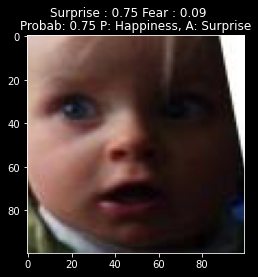

In [132]:
data_module.setup("test")
LOG_PATH = 'logs/resnet18-e1-rgt-pretrainedt/'
    
evaluate(facial_model, data_module.test_dataloader(), log_path=LOG_PATH, testing=True)
'1'

Time: 21.99864387512207 ms
Ind: 0
Surprise : 0.01
Fear : 0.01
Disgust : 0.04
Happiness : 0.01
Sadness : 0.74
Anger : 0.01
Neutral : 0.18

Ind: 1
Surprise : 0.01
Fear : 0.0
Disgust : 0.25
Happiness : 0.02
Sadness : 0.01
Anger : 0.67
Neutral : 0.03



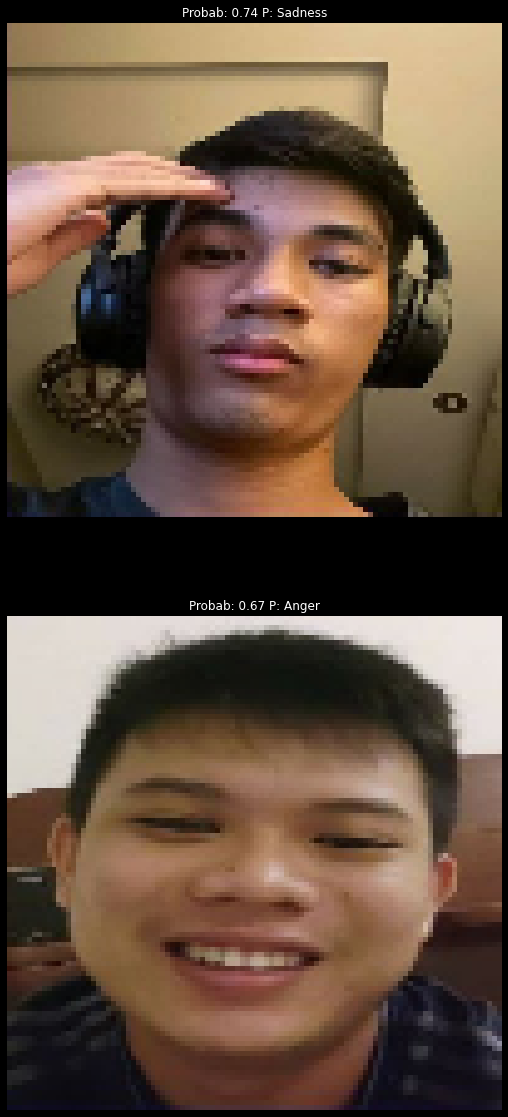

In [ ]:
def predict(model, paths):
    row =len(paths)
    col = 1
    i = 1
    plt.figure(figsize=(25, 20))
    
    with torch.no_grad():
        model.eval()
        start_time = time.time()
        images = torch.Tensor([transforms.Resize((100, 100))(load_image(x)).numpy() for x in paths]).to(DEVICE)
        
        outputs = model(images)
        end_time = time.time()
        
        print("Time:", (end_time-start_time) * 1000, "ms")
        
        # print(outputs[0])
        probabs = nn.functional.softmax(outputs, dim=1)
        predicted = torch.argmax(probabs, dim=1).long()
        
        for ind, pred in enumerate(predicted):
            # if i > row * col:
            #     break
            
            subplot = plt.subplot(row, col, i, label=pred)
            if images[ind].shape[0] == 1:
                subplot.imshow(images[ind].detach().cpu().numpy().squeeze(), cmap='gray')
            else:
                subplot.imshow(images[ind].detach().cpu().numpy().transpose(1, 2, 0))
                
            subplot.axis('off')
            subplot.set_title("Probab: " + str(round(probabs[ind][pred].item() * 100) / 100) + " P: " + CLASS_LABELS[str(pred.item())])
            print("Ind:", ind)
            for index, probab in enumerate(probabs[ind]):
                print(CLASS_LABELS[str(index)], ":", round(probab.item() * 100) / 100)
            print()
            i += 1
            
predict(facial_model, ['./dataset/test/bunnarith.jpg', './dataset/test/sovath.jpg'])

In [ ]:
if not exists('./checkpoints/resnet18-requires-grad-20ep.pt'):
    torch.save(facial_model.state_dict(), './checkpoints/resnet18-requires-grad-20ep.pt')

In [ ]:
model = FacialClassificationResNet18()
model.load_state_dict(torch.load('./checkpoints/resnet18-requires-grad.pt'))

<All keys matched successfully>

In [ ]:
from time import sleep
import cv2
import numpy as np

face_classifier = cv2.CascadeClassifier(r'./cv2/haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(0)

while True:
    facial_model.eval()
    _, frame = cap.read()
    labels = []
    rgb = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    faces = face_classifier.detectMultiScale(rgb, scaleFactor=1.2, minNeighbors=5)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,255),2)
        roi_rgb = rgb[y:y+h,x:x+w]
        roi_rgb = cv2.resize(roi_rgb,(100,100))
        # print(roi_rgb.shape)
        if np.sum(roi_rgb) != 0:
            # roi = torch.Tensor(roi_rgb.reshape(3, 100, 100)).unsqueeze_(dim=0).to(DEVICE)
            roi = transforms.ToTensor()(roi_rgb).unsqueeze_(dim=0).to(DEVICE)

            prediction = nn.functional.softmax(facial_model(roi), dim=1)[0]
            # print(prediction.argmax())
            ind = prediction.argmax().item()
            label= CLASS_LABELS[str(ind)]
            label_position = (x,y)
            cv2.putText(frame,label + " " + str(round(prediction[ind].item() * 100) / 100),label_position,cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
        else:
            cv2.putText(frame,'No Faces',(30,80),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
        
    cv2.imshow('Emotion Detector',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# plt.imshow(roi[0].detach().cpu().numpy().transpose(1, 2, 0))
# plt.imshow(roi_rgb)